In [3]:
import os
IMAGES_PATH = "/home/luminoso/thesis/gjc-ml-2018mar/"
def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
# Load serialized dataframe

import pickle
import pandas as pd

# [86400, 21600, 7200, 3600, 900]

file = "df_900_0.3_v3.raw"

df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame


In [5]:
df.shape

(55484, 64)

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
import numpy as np


class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.

    The input to this transformer should be an array-like of integers or
    strings, denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot (aka one-of-K or dummy)
    encoding scheme (``encoding='onehot'``, the default) or converted
    to ordinal integers (``encoding='ordinal'``).

    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.

    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.

    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):

        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.

    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:

        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories must be sorted and should not mix
          strings and numeric values.

        The used categories can be found in the ``categories_`` attribute.

    dtype : number type, default np.float64
        Desired dtype of output.

    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros. In the inverse transform, an unknown category
        will be denoted as None.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.

    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting
        (in order corresponding with output of ``transform``).

    Examples
    --------
    Given a dataset with two features, we let the encoder find the unique
    values per feature and transform the data to a binary one-hot encoding.

    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> X = [['Male', 1], ['Female', 3], ['Female', 2]]
    >>> enc.fit(X)
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.categories_
    [array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]
    >>> enc.transform([['Female', 1], ['Male', 4]]).toarray()
    array([[ 1.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.]])
    >>> enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])
    array([['Male', 1],
           [None, 2]], dtype=object)

    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to determine the categories of each feature.

        Returns
        -------
        self

        """
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        if self.categories != 'auto':
            for cats in self.categories:
                if not np.all(np.sort(cats) == np.array(cats)):
                    raise ValueError("Unsorted categories are not yet "
                                     "supported")

        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                if self.handle_unknown == 'error':
                    valid_mask = np.in1d(Xi, self.categories[i])
                    if not np.all(valid_mask):
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(self.categories[i])

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using specified encoding scheme.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.

        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.

        """
        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            Xi = X[:, i]
            valid_mask = np.in1d(Xi, self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    Xi = Xi.copy()
                    Xi[~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(Xi)

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        feature_indices = np.cumsum(n_values)

        indices = (X_int + feature_indices[:-1]).ravel()[mask]
        indptr = X_mask.sum(axis=1).cumsum()
        indptr = np.insert(indptr, 0, 0)
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csr_matrix((data, indices, indptr),
                                shape=(n_samples, feature_indices[-1]),
                                dtype=self.dtype)
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

    def inverse_transform(self, X):
        """Convert back the data to the original representation.

        In case unknown categories are encountered (all zero's in the
        one-hot encoding), ``None`` is used to represent this category.

        Parameters
        ----------
        X : array-like or sparse matrix, shape [n_samples, n_encoded_features]
            The transformed data.

        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Inverse transformed array.

        """
        check_is_fitted(self, 'categories_')
        X = check_array(X, accept_sparse='csr')

        n_samples, _ = X.shape
        n_features = len(self.categories_)
        n_transformed_features = sum([len(cats) for cats in self.categories_])

        # validate shape of passed X
        msg = ("Shape of the passed X data is not correct. Expected {0} "
               "columns, got {1}.")
        if self.encoding == 'ordinal' and X.shape[1] != n_features:
            raise ValueError(msg.format(n_features, X.shape[1]))
        elif (self.encoding.startswith('onehot')
              and X.shape[1] != n_transformed_features):
            raise ValueError(msg.format(n_transformed_features, X.shape[1]))

        # create resulting array of appropriate dtype
        dt = np.find_common_type([cat.dtype for cat in self.categories_], [])
        X_tr = np.empty((n_samples, n_features), dtype=dt)

        if self.encoding == 'ordinal':
            for i in range(n_features):
                labels = X[:, i].astype('int64')
                X_tr[:, i] = self.categories_[i][labels]

        else:  # encoding == 'onehot' / 'onehot-dense'
            j = 0
            found_unknown = {}

            for i in range(n_features):
                n_categories = len(self.categories_[i])
                sub = X[:, j:j + n_categories]

                # for sparse X argmax returns 2D matrix, ensure 1D array
                labels = np.asarray(_argmax(sub, axis=1)).flatten()
                X_tr[:, i] = self.categories_[i][labels]

                if self.handle_unknown == 'ignore':
                    # ignored unknown categories: we have a row of all zero's
                    unknown = np.asarray(sub.sum(axis=1) == 0).flatten()
                    if unknown.any():
                        found_unknown[i] = unknown

                j += n_categories

            # if ignored are found: potentially need to upcast result to
            # insert None values
            if found_unknown:
                if X_tr.dtype != object:
                    X_tr = X_tr.astype(object)

                for idx, mask in found_unknown.items():
                    X_tr[mask, idx] = None

        return X_tr

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

## Pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attribs = list(df.drop("entity", axis=1))  # numerical attributes

cat_attribs = ["entity"]  # categorical attributes

# numerical and categorical pipelines
num_pipeline = Pipeline([
    #        ('imputer', Imputer(strategy="median")),
    #        ('attribs_adder', CombinedAttributesAdder()),
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="ordinal")),
])

In [9]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    #("cat_pipeline", cat_pipeline),
])


In [10]:
from sklearn.utils import shuffle
df = shuffle(df)

In [11]:
fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

In [12]:
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [ ]:
algos =[ (svm.SVC(),'svm svc'), # C-Support Vector Classification.
         (svm.LinearSVC(), 'svm_linear'), # Linear Support Vector Classification.
         (svm.NuSVC(), 'nusvc'), # Nu-Support Vector Classification.
         (svm.NuSVR(), 'nusvr'), # Nu Support Vector Regression.
         (svm.SVR(),'svr'), # Epsilon-Support Vector Regression.
         (DecisionTreeClassifier(),'dtree'),
         (DecisionTreeRegressor(),'dtreerg'),
         (KNeighborsClassifier(n_neighbors=3),'near'),
         (MLPClassifier(solver='adam',
                           alpha=1e-5,
                           hidden_layer_sizes=(5, 2),
                           #random_state=1,
                           max_iter=10000,
                           learning_rate='adaptive'),'neural'),
        (KNeighborsClassifier(3),'knei_3'),
        #(GaussianProcessClassifier(1.0 * RBF(1.0)),'gaussian'),
        (RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),'randomforest'),
        (AdaBoostClassifier(),'adaboost'),
        (GaussianNB(),'gaussianNB'),
        (QuadraticDiscriminantAnalysis(),'quadratic')
]


for al in algos:
    classifier, name = al
    
    scores = cross_val_score(classifier,
                             fulldata,
                             fulldata_labels_ordinal.ravel()
                             #scoring='accuracy'
                            )

    print("Accuracy %s: %0.2f (+/- %0.4f)" % (name, scores.mean(), scores.std() * 2 * 100))

In [13]:
df_cat = df['entity']
df_encoded, df_categories = df_cat.factorize()

In [14]:
df_categories

Index(['np_nuc.raw', 'np_tohiba.raw', 'np_windows10x86.raw', 'np_freebsd.raw',
       'np_ubuntu.raw', 'np_x58pc.raw'],
      dtype='object')

In [15]:
fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

dtc = DecisionTreeClassifier()
scores = cross_val_score(dtc,
                             fulldata,
                             fulldata_labels_ordinal.ravel()
                             #scoring='accuracy'
                            )

In [16]:
from sklearn.model_selection import cross_val_predict
dtc = DecisionTreeClassifier()
y_train_pred = cross_val_predict(dtc,
                             fulldata,
                             fulldata_labels_ordinal.ravel()
                             #scoring='accuracy'
                            )


In [17]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(fulldata_labels_ordinal.ravel(),y_train_pred)


In [18]:
conf_mx

array([[8926,    2,  258,    0,    0,  252],
       [   2, 8459,  504,    4,    2,  467],
       [   5,   40, 7136,   24,   14, 2219],
       [   0,    3,  914, 7594,  111,  816],
       [   3,    2, 1076,   85, 6247,  881],
       [   2,    7, 3395,    4,    4, 6026]])

Saving figure conf_mat


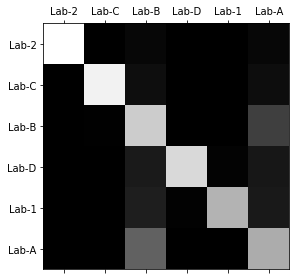

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

alpha = ['Lab-2', 'Lab-C', 'Lab-B', 'Lab-D', 'Lab-1', 'Lab-A']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx, cmap=plt.cm.gray)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

save_fig('conf_mat')

plt.show()

Saving figure conf_mat_errors


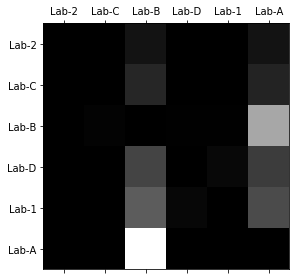

In [20]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
#plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
#plt.matshow(norm_conf_mx)

#Index(['np_windows10x86.raw', 'np_tohiba.raw', 'np_x58pc.raw', 'np_freebsd.raw', 'np_ubuntu.raw', 'np_nuc.raw'
    
# 1 ubuntu
# 2 windows10x86
# a nuc
# b x58
# c toshiba
# d freebsd    
alpha = ['Lab-2', 'Lab-C', 'Lab-B', 'Lab-D', 'Lab-1', 'Lab-A']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.gray)
#fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

save_fig('conf_mat_errors')

plt.show()

In [21]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

Automatically created module for IPython interactive environment
Normalized confusion matrix
[[9.40e-01 0.00e+00 3.18e-02 0.00e+00 0.00e+00 2.81e-02]
 [0.00e+00 8.97e-01 5.95e-02 4.16e-04 0.00e+00 4.28e-02]
 [4.23e-04 4.66e-03 7.82e-01 2.96e-03 1.27e-03 2.09e-01]
 [0.00e+00 0.00e+00 9.90e-02 8.13e-01 9.39e-03 7.90e-02]
 [0.00e+00 0.00e+00 1.29e-01 1.10e-02 7.58e-01 1.02e-01]
 [0.00e+00 0.00e+00 3.76e-01 0.00e+00 4.21e-04 6.24e-01]]
Saving figure conf_mat
Normalized confusion matrix
[[0.   0.   0.53 0.   0.   0.47]
 [0.   0.   0.58 0.   0.   0.42]
 [0.   0.02 0.   0.01 0.01 0.96]
 [0.   0.   0.53 0.   0.05 0.42]
 [0.   0.   0.53 0.05 0.   0.42]
 [0.   0.   1.   0.   0.   0.  ]]
Saving figure conf_mat_errors


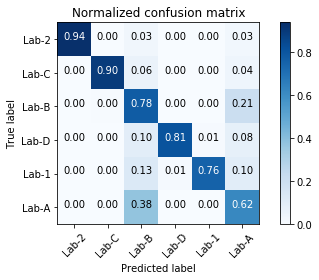

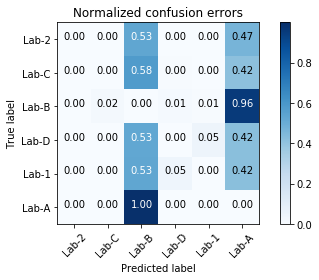

In [22]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
#iris = datasets.load_iris()
X = fulldata
y = fulldata_labels_ordinal.ravel()
class_names = ['Lab-2', 'Lab-C', 'Lab-B', 'Lab-D', 'Lab-1', 'Lab-A']


# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = DecisionTreeClassifier()
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

save_fig('conf_mat')


plt.figure()

row_sums = cnf_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = cnf_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plot_confusion_matrix(norm_conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion errors')

save_fig('conf_mat_errors')

plt.show()

In [23]:
from sklearn.decomposition import PCA

# graficos

In [24]:
#filter
#df_4 = df[df.entity != 'np_windows10x86.raw']
df_4 = df

df_4 = df_4[df_4.entity != 'np_ubuntu.raw']
#df_4 = df_4[df_4.entity != 'np_x58pc.raw']
#df_4 = df_4[df_4.entity != 'np_tohiba.raw']
df_4 = df_4[df_4.entity != 'np_nuc.raw']
#df_4 = df_4[df_4.entity != 'np_freebsd.raw']

print(df_4['entity'].value_counts())

fulldata = full_pipeline.fit_transform(df_4)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df_4['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)


pca = PCA(n_components=2)
pca.fit(fulldata)

fulldata_pca2 = pca.transform(fulldata)

np_x58pc.raw           9438
np_freebsd.raw         9438
np_tohiba.raw          9438
np_windows10x86.raw    8294
Name: entity, dtype: int64


In [25]:
df_4.shape

(36608, 64)

In [26]:
fulldata_labels_ordinal.shape

(36608, 1)

Automatically created module for IPython interactive environment
training... ...done
Saving figure svm_pca2


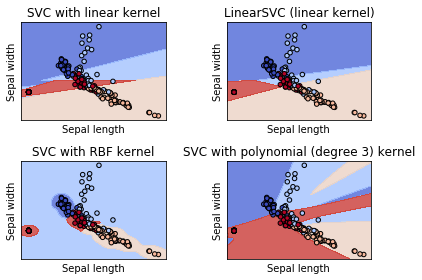

In [32]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with
#iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
#X = iris.data[:, :2]
#y = iris.target

X = fulldata_pca2[:300]
y = fulldata_labels_ordinal.ravel()[:300]

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))
models = (clf.fit(X, y) for clf in models)
print("training...", end=" ")
#models = (clf.fit(fulldata_pca2, fulldata_labels_ordinal.ravel()) for clf in models)
print("...done")


# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    
save_fig('svm_pca2')

plt.show()

# multi

In [36]:
 


fulldata = full_pipeline.fit_transform(df_A)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df_A['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal_A = cat_encoder.fit_transform(fulldata_labels)


pca = PCA(n_components=2)
pca.fit(fulldata)
fulldata_pca2_A = pca.transform(fulldata)


# dois
#df_B = df[df.entity != 'np_windows10x86.raw']
df_B = df
#df_B = df_B[df_B.entity != 'np_ubuntu.raw']
df_B = df_B[df_B.entity != 'np_x58pc.raw']
df_B = df_B[df_B.entity != 'np_tohiba.raw']
df_B = df_B[df_B.entity != 'np_nuc.raw']
df_B = df_B[df_B.entity != 'np_freebsd.raw']


fulldata = full_pipeline.fit_transform(df_B)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df_B['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal_B = cat_encoder.fit_transform(fulldata_labels)


pca = PCA(n_components=2)
pca.fit(fulldata)
fulldata_pca2_B = pca.transform(fulldata)






In [35]:
df_A['entity'].value_counts()

np_x58pc.raw           9438
np_windows10x86.raw    8294
Name: entity, dtype: int64

Automatically created module for IPython interactive environment
Saving figure multi_different


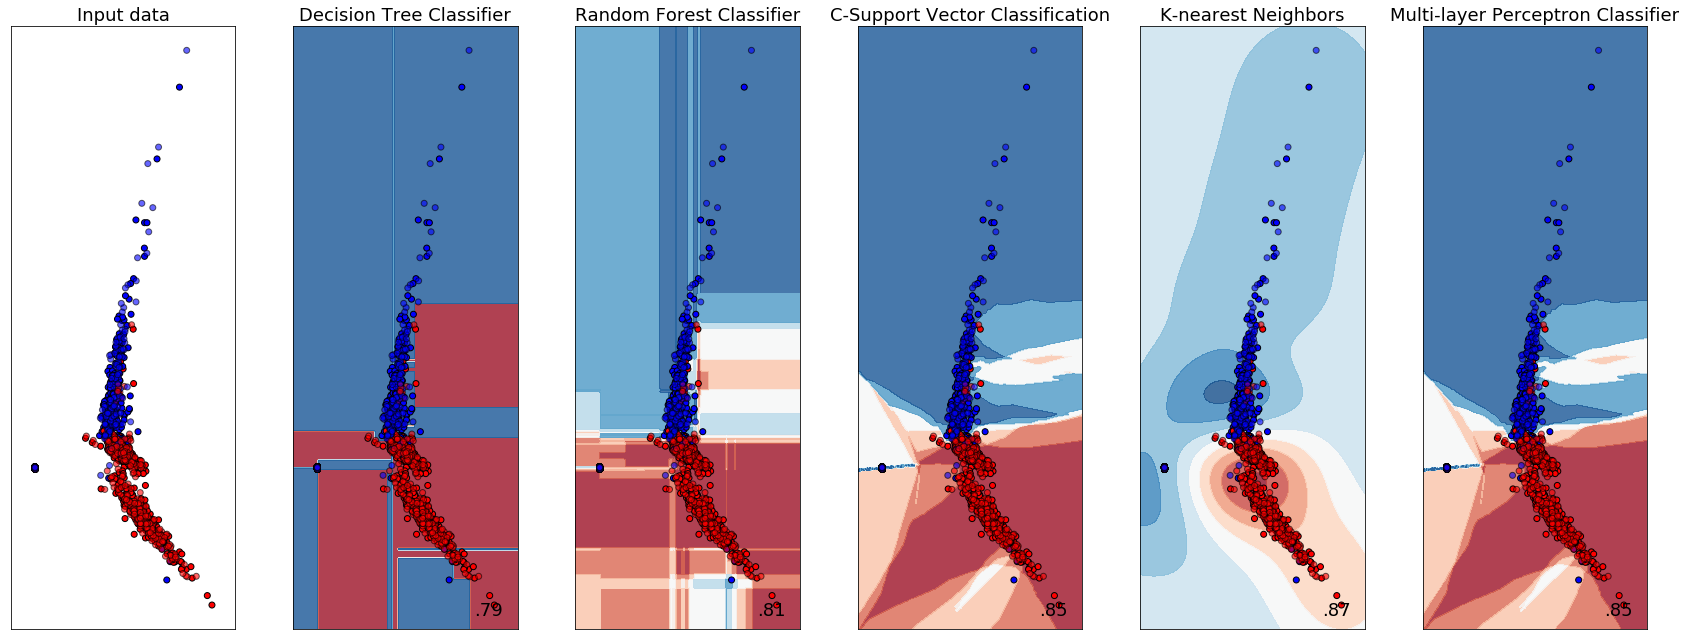

In [41]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]



names =["Decision Tree Classifier",
        "Random Forest Classifier",
        "C-Support Vector Classification",
        "K-nearest Neighbors",
        "Multi-layer Perceptron Classifier"
       ]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    SVC(),
    KNeighborsClassifier(),
    MLPClassifier() 
]
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    #DecisionTreeClassifier(max_depth=5),
    
    #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    
    #MLPClassifier(alpha=1),
    #AdaBoostClassifier(),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [None #make_moons(noise=0.3, random_state=0),)
            #make_circles(noise=0.2, factor=0.5, random_state=1),
            #linearly_separable
            ]
             
datasets = [
    (fulldata_pca2_A[:2000], fulldata_labels_ordinal_A.ravel()[:2000])
    #(fulldata_pca2_B[:2000], fulldata_labels_ordinal_B.ravel()[:2000])
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    
    X, y = ds
    
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data", size=18)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name,size=18)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=18, horizontalalignment='right')
        i += 1

plt.tight_layout()
save_fig('multi_different')
plt.show()

Automatically created module for IPython interactive environment
Saving figure multi_same


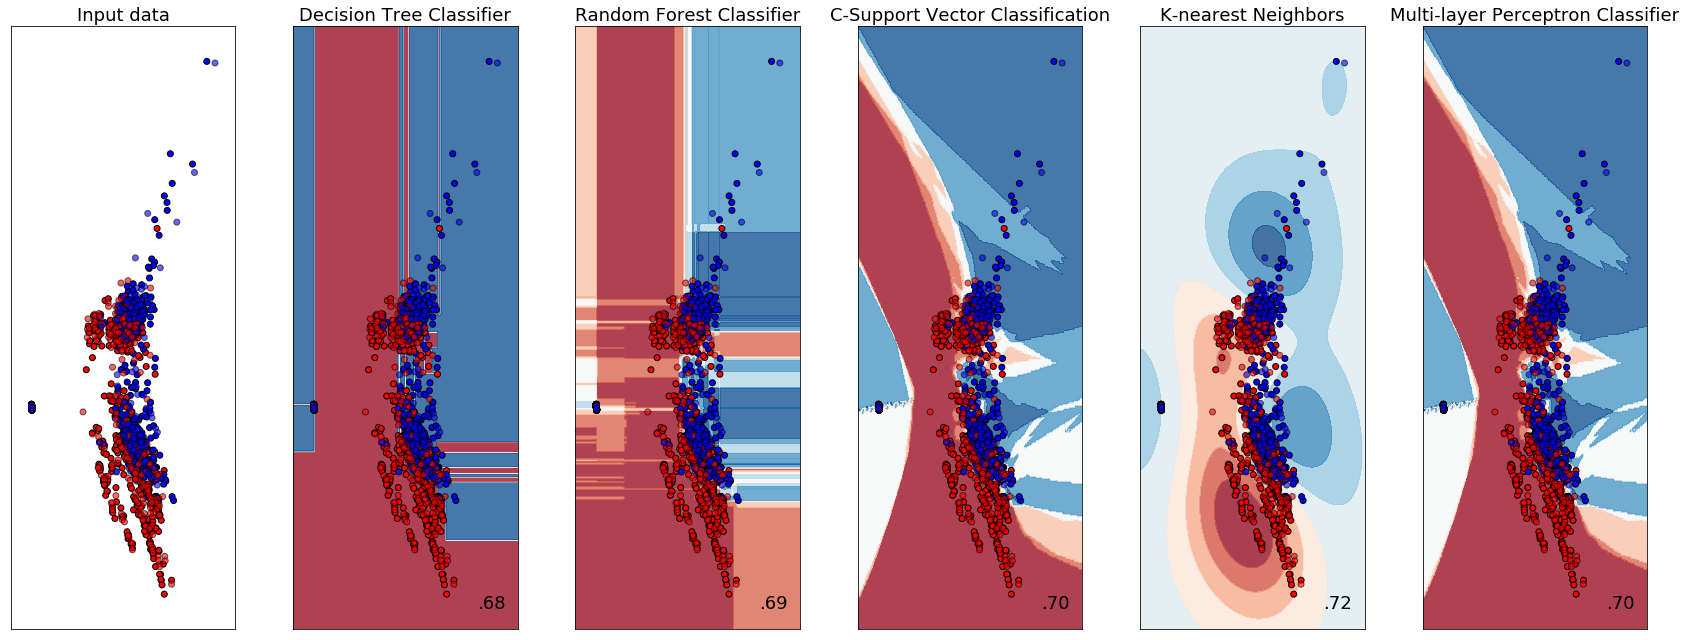

In [42]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]



names =["Decision Tree Classifier",
        "Random Forest Classifier",
        "C-Support Vector Classification",
        "K-nearest Neighbors",
        "Multi-layer Perceptron Classifier"
       ]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    SVC(),
    KNeighborsClassifier(),
    MLPClassifier() 
]
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    #DecisionTreeClassifier(max_depth=5),
    
    #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    
    #MLPClassifier(alpha=1),
    #AdaBoostClassifier(),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [None #make_moons(noise=0.3, random_state=0),)
            #make_circles(noise=0.2, factor=0.5, random_state=1),
            #linearly_separable
            ]
             
datasets = [
    #(fulldata_pca2_A[:2000], fulldata_labels_ordinal_A.ravel()[:2000])
    (fulldata_pca2_B[:2000], fulldata_labels_ordinal_B.ravel()[:2000])
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    
    X, y = ds
    
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data", size=18)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name,size=18)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=18, horizontalalignment='right')
        i += 1

plt.tight_layout()
save_fig('multi_same')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)